<a href="https://colab.research.google.com/github/yingzibu/MOL2AE/blob/main/examples/AttentiveFP_NN_ADME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet

!pip install dgllife --quiet
!pip install molvs --quiet

# !pip install dgl==1.1 --quiet # cpu version, usable for calculation

!pip uninstall dgl -y # dgl cuda version for training using gpu
!pip install  dgl -f https://data.dgl.ai/wheels/cu118/repo.html --quiet
!pip install  dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.3/91.3 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 98.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score
import math

def get_preds(threshold, probabilities):
    try:
        if probabilities.shape[1] == 2: probabilities = probabilities[:, 1]
    except: pass
    return [1 if prob > threshold else 0 for prob in probabilities]

def evaluate_model(TP, FP, TN, FN):

    ACCURACY = (TP + TN) / (TP+FP+TN+FN)
    SE = TP/(TP+FN)
    recall = SE
    SP = TN/(TN+FP)
    weighted_accuracy = (SE + SP) / 2

    precision = TP / (TP + FP)
    SP = TN/(TN+FP)
    F1 = 2 * precision * recall /(precision + recall)

    temp = (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)
    if temp != 0:
        MCC = (TP*TN-FP*FN)*1.0/(math.sqrt(temp))
    else:
        print('equation for MCC is (TP*TN-FP*FN)*1.0/(math.sqrt(temp))')
        print('TP, FP, TN, FN', TP, FP, TN, FN)
        print('temp=0')
        MCC = 'N/A'

    return ACCURACY,SE, SP, weighted_accuracy, precision, F1, MCC

def evaluate(y_real, y_hat, y_prob):
    TN, FP, FN, TP = confusion_matrix(y_real, y_hat).ravel()
    ACCURACY,SE, SP, weighted_accuracy, precision, F1, \
        MCC  = evaluate_model(TP, FP, TN, FN)
    try:
        if y_prob.shape[1] == 2: proba = y_prob[:, 1]
        else: proba = y_prob
    except: proba = y_prob
    AP = average_precision_score(y_real, proba)
    AUC = roc_auc_score(y_real, proba)
    print('Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP')
    if MCC != 'N/A':
        print("& %5.3f" % (ACCURACY), " &%7.3f" % (weighted_accuracy), " &%15.3f" % (precision),
      " &%10.3f" % (SE), " &%5.3f" % (SP), " &%5.3f" % (F1), "&%5.3f" % (AUC),
      "&%8.3f" % (MCC), "&%8.3f" % (AP))
    else:
        print("& %5.3f" % (ACCURACY), " &%7.3f" % (weighted_accuracy), " &%15.3f" % (precision),
      " &%10.3f" % (SE), " &%5.3f" % (SP), " &%5.3f" % (F1), "&%5.3f" % (AUC), "& ",
        MCC, "&%8.3f" % (AP))

    return ACCURACY, weighted_accuracy, precision, SE, SP, F1, AUC, MCC, AP


In [2]:
from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
# smiles = "Cl.C[C@@]1(O)CCCN1"
# mol = Chem.MolFromSmiles( smiles )
# print( Chem.MolToSmiles( mol  ) ) # mol
# #>>> C[C@@]1(O)CCCN1.Cl

# # remove salt
# # remover = SaltRemover( defnData="[Cl,Br]" ) # define custom list, No spaces allowed
# remover = SaltRemover() # use default saltremover
# stripped = remover.StripMol( mol ) # strip salts
# print( Chem.MolToSmiles( stripped ) ) #  mol w/o salt
# #>>> C[C@@]1(O)CCCN1

# # remove stereo
# Chem.RemoveStereochemistry( stripped )
# print( Chem.MolToSmiles( stripped ) ) # mol w/o salt & stereo

In [4]:
"Reference: https://github.com/Yimeng-Wang/JAK-MTATFP/blob/main/preprocess.py"

from rdkit import Chem
from molvs.normalize import Normalizer, Normalization
from rdkit.Chem.SaltRemover import SaltRemover
from molvs.charge import Reionizer, Uncharger
import torch.nn as nn

from tdc.single_pred import ADME
from rdkit import RDLogger
import warnings
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore")
MASK = -100


def preprocess(smi):
    mol = Chem.MolFromSmiles(smi)
    normalizer = Normalizer()
    new1 = normalizer.normalize(mol)
    remover = SaltRemover()
    new2 = remover(new1)
    neutralize1 = Reionizer()
    new3 = neutralize1(new2)
    neutralize2 = Uncharger()
    new4 = neutralize2(new3)
    new_smiles = Chem.MolToSmiles(new4, kekuleSmiles=False)
    return new_smiles

In [11]:
name_reg = ['Half_Life_Obach', 'Clearance_Hepatocyte_AZ', 'VDss_Lombardo',
         'PPBR_AZ', 'Caco2_Wang', 'Lipophilicity_AstraZeneca',
         'HydrationFreeEnergy_FreeSolv', 'Solubility_AqSolDB']

name_cls = ['BBB_Martins', 'Bioavailability_Ma', 'Pgp_Broccatelli',
             'HIA_Hou', 'PAMPA_NCATS']

name_met_cls = ['CYP2C19_Veith', 'CYP2D6_Veith', 'CYP3A4_Veith',
                       'CYP1A2_Veith', 'CYP2C9_Veith',
                       'CYP2C9_Substrate_CarbonMangels',
                       'CYP2D6_Substrate_CarbonMangels',
                       'CYP3A4_Substrate_CarbonMangels']

names = name_met_cls[:5]

IS_R = False # is regression task
SCALE = False

if IS_R: loss_fn = nn.MSELoss(reduction='sum') # if regression
else: loss_fn = nn.BCEWithLogitsLoss(reduction='sum') # if classification

# If regression, metrics: R2, MAE, MSE, RMSE
# If classification, metrics: Loss, evaluate(y_real, y_hat, y_prob)

names, len(names)


(['CYP2C19_Veith',
  'CYP2D6_Veith',
  'CYP3A4_Veith',
  'CYP1A2_Veith',
  'CYP2C9_Veith'],
 5)

Found local copy...
Loading...
Done!


*************** CYP2C19_Veith ***************


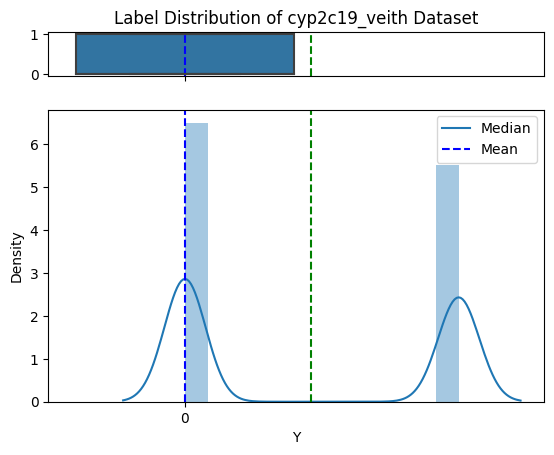

Cleaning mols: 100%|██████████| 2533/2533 [00:06<00:00, 389.52it/s]
Found local copy...
Loading...
Done!


*************** CYP2D6_Veith ***************


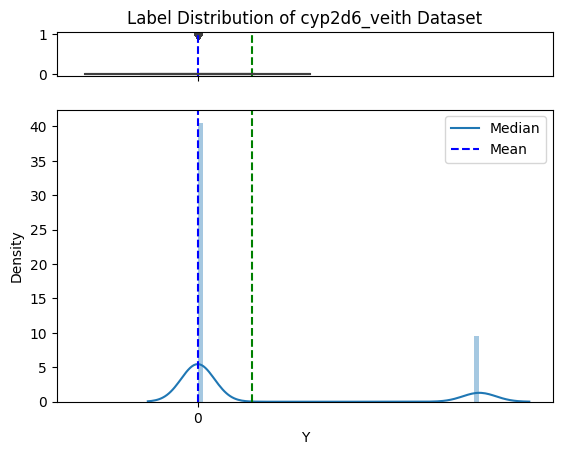

Cleaning mols: 100%|██████████| 2626/2626 [00:06<00:00, 376.53it/s]
Found local copy...
Loading...
Done!


*************** CYP3A4_Veith ***************


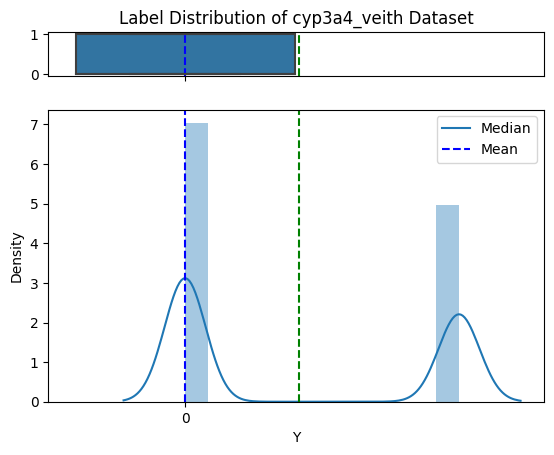

Cleaning mols: 100%|██████████| 2466/2466 [00:06<00:00, 365.50it/s]
Found local copy...
Loading...
Done!


*************** CYP1A2_Veith ***************


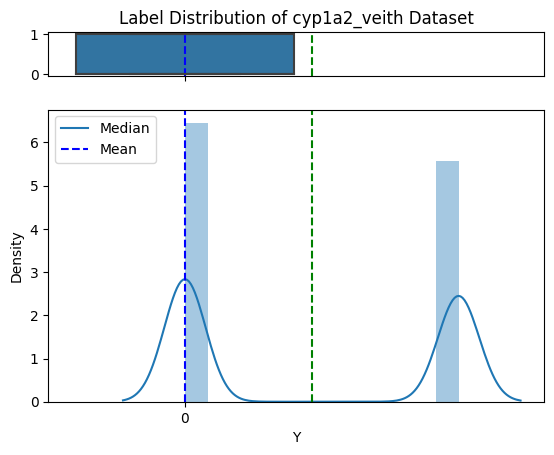

Cleaning mols: 100%|██████████| 2516/2516 [00:06<00:00, 392.69it/s]
Found local copy...
Loading...
Done!


*************** CYP2C9_Veith ***************


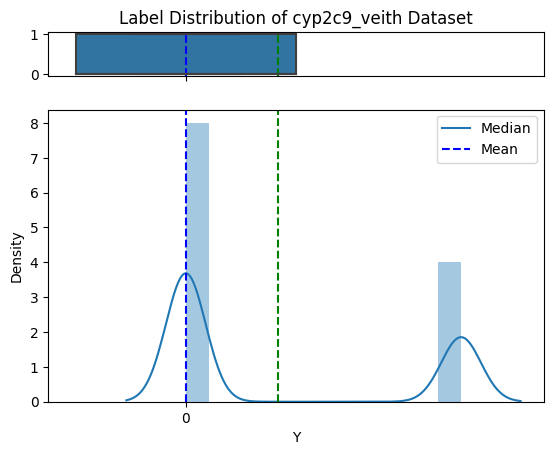

Cleaning mols: 100%|██████████| 2418/2418 [00:06<00:00, 373.81it/s]


(15984, 5384, 9240)

In [6]:
# from tdc.single_pred import ADME
# from rdkit import RDLogger
# import warnings
# RDLogger.DisableLog('rdApp.*')
# warnings.filterwarnings("ignore")
# MASK = -100

def rename_cols(df, name): return df.rename(columns={'Y':name})

def clean_mol(df:pd.DataFrame):
    prev_len = len(df)
    for i in tqdm(range(len(df)), total=len(df), desc='Cleaning mols'):
        try: df.iloc[i]['Drug'] = preprocess(df.iloc[i]['Drug'])
        except: df.drop(i)
    if len(df) != prev_len: print(f'prev len: {prev_len}; after clean: {len(df)}')
    return df.reset_index(drop=True)

def scal(df): # min max scaling
    # df_norm = df.loc[:, df.columns!='Drug'].copy()
    df_norm = df.copy()
    for col in df_norm.columns:
        if col == 'Drug': pass
        else:
            df_norm[col] = (df_norm[col]-df_norm[col].min()
            )/(df_norm[col].max()-df_norm[col].min()) * 10 + 1e-3
    # df_norm['Drug'] = df['Drug']
    return df_norm


for i, name in enumerate(names):
    print('*'*15, name, '*'*15)
    data = ADME(name=name)
    data.label_distribution()
    # data.convert_to_log(form='binding')

    # shoud not convert to log scale for the belowing since it is minus
    # Caco2_Wang                              -7.76
    # Lipophilicity_AstraZeneca               -1.45
    # HydrationFreeEnergy_FreeSolv           -23.62
    # Solubility_AqSolDB                   -13.1719

    split = data.get_split()
    train, valid = clean_mol(split['train']), clean_mol(split['valid'])
    test =  clean_mol(split['test'])

    train = rename_cols(train[['Drug', 'Y']], name)
    valid = rename_cols(valid[['Drug', 'Y']], name)
    test  = rename_cols(test[['Drug', 'Y']],  name)

    if IS_R and SCALE: train, valid, test = scal(train), scal(valid), scal(test)

    if i == 0: trains, valids, tests = train, valid, test
    else:
        trains = trains.merge(train, how='outer')
        valids = valids.merge(valid, how='outer')
        tests = tests.merge(test, how='outer')

# MASK = -100
# trains = trains.fillna(MASK)
# valids = valids.fillna(MASK)
# tests = tests.fillna(MASK)


# trains[trains.eq(0).any(1)]
# valids[valids.eq(0).any(1)]
# tests[tests.eq(0).any(1)]
len(trains), len(valids), len(tests)

In [12]:
trains.head()

,Drug,CYP2C19_Veith,CYP2D6_Veith,CYP3A4_Veith,CYP1A2_Veith,CYP2C9_Veith
0,CC(=O)N(c1ccc2oc(=O)sc2c1)S(=O)(=O)c1cccs1,1.0,0.0,1.0,NaN,NaN
1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,1.0,NaN,NaN,1.0,1.0
2,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,1.0,NaN,NaN,1.0,NaN
3,CC(=O)Nc1cccc(NC(=O)C2CCCN2C(=O)Nc2ccccc2C)c1,0.0,NaN,0.0,NaN,NaN
4,CCC(c1nnnn1CC1CCCO1)N(CCN1CCOCC1)Cc1cc2cc(C)cc...,0.0,0.0,1.0,NaN,0.0


In [281]:
# trains[~trains['VDss_Lombardo'].isnull()]

In [282]:
train.min(), train.max()

(Drug                              C#CCN(C)Cc1ccccc1
 CYP3A4_Substrate_CarbonMangels                    0
 dtype: object,
 Drug                              c1ccccc1
 CYP3A4_Substrate_CarbonMangels           1
 dtype: object)

In [23]:
import pandas as pd

import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import EarlyStopping, Meter
from dgllife.utils import AttentiveFPAtomFeaturizer
from dgllife.utils import AttentiveFPBondFeaturizer
from dgllife.data import MoleculeCSVDataset

def collate_molgraphs(data):
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
        # masks = (labels == MASK).long()
    return smiles, bg, labels, masks


atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
n_feats_num = atom_featurizer.feat_size('hv')
e_feats_num = bond_featurizer.feat_size('he')

In [24]:
import time
named_tuple = time.localtime() # get struct_time
time_string = time.strftime("%m_%d_%Y_%H:%M:%S", named_tuple)

params = {'node_featurizer': atom_featurizer,
          'edge_featurizer': bond_featurizer,
          'smiles_column': 'Drug',
        #   'cache_file_path': time_string+'.bin',
          'task_names': names, 'load': True, 'n_jobs': len(names)}


train_datasets = MoleculeCSVDataset(trains, cache_file_path=f'train_{time_string}.bin', **params)
valid_datasets = MoleculeCSVDataset(valids,cache_file_path=f'valid_{time_string}.bin', **params)
test_datasets = MoleculeCSVDataset(tests, cache_file_path=f'test_{time_string}.bin', **params)

batch_size = 64
loader_params ={'batch_size': batch_size,
                'shuffle': True,
                'collate_fn': collate_molgraphs}

train_loader = DataLoader(train_datasets, **loader_params)
valid_loader = DataLoader(valid_datasets, **loader_params)
test_loader  = DataLoader(test_datasets,  **loader_params)

Processing dgl graphs from scratch...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 7690 tasks      | elapsed:    9.6s
[Parallel(n_jobs=5)]: Done 15984 out of 15984 | elapsed:   17.0s finished


Processing dgl graphs from scratch...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 5375 out of 5384 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 5384 out of 5384 | elapsed:    5.6s finished


Processing dgl graphs from scratch...


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 8773 tasks      | elapsed:    7.6s
[Parallel(n_jobs=5)]: Done 9240 out of 9240 | elapsed:    7.9s finished


In [25]:
cuda = torch.cuda.is_available()
if cuda: device = 'cuda'
else: device = 'cpu'
n_layers = 3
dropout = 0.5

model = model_zoo.AttentiveFPPredictor(
            node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
            num_layers=n_layers, num_timesteps=1, graph_feat_size=300,
            n_tasks=len(names), dropout=dropout).to(device)

In [27]:
def train_epoch(epoch, model, data_loader, loss_func, optimizer):
    model.train()
    losses = 0
    train_meter = Meter()
    for batch_id, batch_data in tqdm(enumerate(data_loader),
                                     total=len(data_loader),
                                     desc=f'Epoch {epoch}'):
        smiles, bg, labels, masks = batch_data
        bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
        n_feats = bg.ndata.pop('hv').to(device)
        e_feats = bg.edata.pop('he').to(device)

        pred = model(bg, n_feats, e_feats)
        mask = masks < 1
        loss = loss_func(pred[~mask], labels[~mask])
        del mask
        # loss = (loss_func(pred, labels)*(masks!=0).float()).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_meter.update(pred, labels, masks)
        del pred
        del labels
        del masks
        losses += loss.item()
        # losses.append(loss.item())

    total_r2 = np.mean(train_meter.compute_metric('r2'))
    total_loss = losses / len(data_loader.dataset)
    # if epoch % 10 == 0 and epoch != 0:
    print(f'[Train] R2: {total_r2:.3f}, Loss: {total_loss:.3f}')

    return total_r2, total_loss

def eval_epoch(model, data_loader, loss_func):
    model.eval()
    val_losses = 0
    eval_meter = Meter()
    with torch.no_grad():
        for batch_data in data_loader:
            smiles, bg, labels, masks = batch_data
            bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
            n_feats = bg.ndata.pop('hv').to(device)
            e_feats = bg.edata.pop('he').to(device)
            val_pred = model(bg, n_feats, e_feats)
            mask = masks < 1
            val_loss = loss_func(val_pred[~mask], labels[~mask])
            # val_loss = (loss_func(val_pred, labels)*(masks!=0).float()).mean()
            # val_losses.append(val_loss.item())
            val_losses += val_loss.item()
            eval_meter.update(val_pred, labels, masks)
            del val_pred
            del labels
            del masks
            del n_feats
            del e_feats
        total_score = np.mean(eval_meter.compute_metric('r2'))
        total_loss = val_losses / len(data_loader.dataset)
        print(f'[Valid] R2: {total_score:.3f}, Loss: {total_loss:.3f}')
    return total_score, total_loss


In [28]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
stopper = EarlyStopping(mode='lower', patience=30)
n_epochs = 500
best_epoch = 0
min_loss = 100000

In [30]:
if best_epoch != 0:
    model.load_state_dict(torch.load('ckpt.pt', map_location=device))

for epoch in range(best_epoch, best_epoch + n_epochs):
    score = train_epoch(epoch, model, train_loader, loss_fn, optimizer)
    val_score = eval_epoch(model, valid_loader, loss_fn)
    early_stop = stopper.step(val_score[1], model)
    if val_score[1] < min_loss and epoch > 3:
        print(f'prev min loss {min_loss:.3f}, now better loss {val_score[1]:.3f}')
        min_loss = val_score[1]
        torch.save(model.state_dict(), 'ckpt.pt')
        print(f'save model at epoch: {epoch}')
        best_epoch = epoch

    if early_stop: print('early stop'); break


Epoch 0: 100%|██████████| 250/250 [00:05<00:00, 42.71it/s]


[Train] R2: 0.150, Loss: 1.473
[Valid] R2: 0.252, Loss: 2.519


Epoch 1: 100%|██████████| 250/250 [00:05<00:00, 47.84it/s]


[Train] R2: 0.262, Loss: 1.282
[Valid] R2: 0.332, Loss: 2.293


Epoch 2: 100%|██████████| 250/250 [00:05<00:00, 48.99it/s]


[Train] R2: 0.316, Loss: 1.206
[Valid] R2: 0.352, Loss: 2.185


Epoch 3: 100%|██████████| 250/250 [00:05<00:00, 48.09it/s]


[Train] R2: 0.338, Loss: 1.168
[Valid] R2: 0.379, Loss: 2.136


Epoch 4: 100%|██████████| 250/250 [00:05<00:00, 47.27it/s]


[Train] R2: 0.363, Loss: 1.124
[Valid] R2: 0.391, Loss: 2.084
prev min loss 100000, now better loss 2.0837535229076325
save model at epoch: 4


Epoch 5: 100%|██████████| 250/250 [00:05<00:00, 45.61it/s]


[Train] R2: 0.378, Loss: 1.096
[Valid] R2: 0.413, Loss: 2.031
prev min loss 2.0837535229076325, now better loss 2.031040868057112
save model at epoch: 5


Epoch 6: 100%|██████████| 250/250 [00:05<00:00, 47.49it/s]


[Train] R2: 0.386, Loss: 1.083
[Valid] R2: 0.423, Loss: 1.988
prev min loss 2.031040868057112, now better loss 1.9878368764203673
save model at epoch: 6


Epoch 7: 100%|██████████| 250/250 [00:05<00:00, 48.07it/s]


[Train] R2: 0.399, Loss: 1.052
[Valid] R2: 0.421, Loss: 1.984
prev min loss 1.9878368764203673, now better loss 1.983816438514009
save model at epoch: 7


Epoch 8: 100%|██████████| 250/250 [00:05<00:00, 48.35it/s]


[Train] R2: 0.411, Loss: 1.035
[Valid] R2: 0.433, Loss: 1.906
prev min loss 1.983816438514009, now better loss 1.9061766530581996
save model at epoch: 8


Epoch 9: 100%|██████████| 250/250 [00:05<00:00, 47.07it/s]


[Train] R2: 0.417, Loss: 1.014
[Valid] R2: 0.431, Loss: 1.944
EarlyStopping counter: 1 out of 30


Epoch 10: 100%|██████████| 250/250 [00:05<00:00, 48.41it/s]


[Train] R2: 0.421, Loss: 1.007
[Valid] R2: 0.443, Loss: 1.885
prev min loss 1.9061766530581996, now better loss 1.885309858298479
save model at epoch: 10


Epoch 11: 100%|██████████| 250/250 [00:05<00:00, 47.16it/s]


[Train] R2: 0.429, Loss: 0.993
[Valid] R2: 0.448, Loss: 1.879
prev min loss 1.885309858298479, now better loss 1.8790214832801282
save model at epoch: 11


Epoch 12: 100%|██████████| 250/250 [00:05<00:00, 48.67it/s]


[Train] R2: 0.434, Loss: 0.982
[Valid] R2: 0.448, Loss: 1.886
EarlyStopping counter: 1 out of 30


Epoch 13: 100%|██████████| 250/250 [00:05<00:00, 47.55it/s]


[Train] R2: 0.439, Loss: 0.967
[Valid] R2: 0.459, Loss: 1.845
prev min loss 1.8790214832801282, now better loss 1.8454734967502313
save model at epoch: 13


Epoch 14: 100%|██████████| 250/250 [00:05<00:00, 47.61it/s]


[Train] R2: 0.445, Loss: 0.955
[Valid] R2: 0.453, Loss: 1.884
EarlyStopping counter: 1 out of 30


Epoch 15: 100%|██████████| 250/250 [00:05<00:00, 47.38it/s]


[Train] R2: 0.454, Loss: 0.935
[Valid] R2: 0.468, Loss: 1.791
prev min loss 1.8454734967502313, now better loss 1.7911468021528498
save model at epoch: 15


Epoch 16: 100%|██████████| 250/250 [00:05<00:00, 48.37it/s]


[Train] R2: 0.450, Loss: 0.936
[Valid] R2: 0.464, Loss: 1.804
EarlyStopping counter: 1 out of 30


Epoch 17: 100%|██████████| 250/250 [00:05<00:00, 47.54it/s]


[Train] R2: 0.458, Loss: 0.924
[Valid] R2: 0.468, Loss: 1.826
EarlyStopping counter: 2 out of 30


Epoch 18: 100%|██████████| 250/250 [00:05<00:00, 48.66it/s]


[Train] R2: 0.458, Loss: 0.917
[Valid] R2: 0.471, Loss: 1.781
prev min loss 1.7911468021528498, now better loss 1.78116426908398
save model at epoch: 18


Epoch 19: 100%|██████████| 250/250 [00:05<00:00, 47.21it/s]


[Train] R2: 0.463, Loss: 0.909
[Valid] R2: 0.470, Loss: 1.781
prev min loss 1.78116426908398, now better loss 1.781141452300243
save model at epoch: 19


Epoch 20: 100%|██████████| 250/250 [00:05<00:00, 48.68it/s]


[Train] R2: 0.469, Loss: 0.893
[Valid] R2: 0.471, Loss: 1.779
prev min loss 1.781141452300243, now better loss 1.778857084223808
save model at epoch: 20


Epoch 21: 100%|██████████| 250/250 [00:05<00:00, 46.49it/s]


[Train] R2: 0.475, Loss: 0.880
[Valid] R2: 0.468, Loss: 1.775
prev min loss 1.778857084223808, now better loss 1.7752750795473236
save model at epoch: 21


Epoch 22: 100%|██████████| 250/250 [00:05<00:00, 45.99it/s]


[Train] R2: 0.480, Loss: 0.871
[Valid] R2: 0.471, Loss: 1.745
prev min loss 1.7752750795473236, now better loss 1.7451632050466104
save model at epoch: 22


Epoch 23: 100%|██████████| 250/250 [00:05<00:00, 45.58it/s]


[Train] R2: 0.482, Loss: 0.860
[Valid] R2: 0.467, Loss: 1.769
EarlyStopping counter: 1 out of 30


Epoch 24: 100%|██████████| 250/250 [00:05<00:00, 44.96it/s]


[Train] R2: 0.485, Loss: 0.850
[Valid] R2: 0.475, Loss: 1.747
EarlyStopping counter: 2 out of 30


Epoch 25: 100%|██████████| 250/250 [00:05<00:00, 48.16it/s]


[Train] R2: 0.489, Loss: 0.844
[Valid] R2: 0.478, Loss: 1.763
EarlyStopping counter: 3 out of 30


Epoch 26: 100%|██████████| 250/250 [00:05<00:00, 47.73it/s]


[Train] R2: 0.493, Loss: 0.832
[Valid] R2: 0.476, Loss: 1.740
prev min loss 1.7451632050466104, now better loss 1.7402382583239535
save model at epoch: 26


Epoch 27: 100%|██████████| 250/250 [00:05<00:00, 48.12it/s]


[Train] R2: 0.495, Loss: 0.822
[Valid] R2: 0.467, Loss: 1.768
EarlyStopping counter: 1 out of 30


Epoch 28: 100%|██████████| 250/250 [00:05<00:00, 47.36it/s]


[Train] R2: 0.497, Loss: 0.813
[Valid] R2: 0.475, Loss: 1.746
EarlyStopping counter: 2 out of 30


Epoch 29: 100%|██████████| 250/250 [00:05<00:00, 47.07it/s]


[Train] R2: 0.501, Loss: 0.804
[Valid] R2: 0.485, Loss: 1.759
EarlyStopping counter: 3 out of 30


Epoch 30: 100%|██████████| 250/250 [00:05<00:00, 46.62it/s]


[Train] R2: 0.504, Loss: 0.798
[Valid] R2: 0.482, Loss: 1.732
prev min loss 1.7402382583239535, now better loss 1.7324182726905009
save model at epoch: 30


Epoch 31: 100%|██████████| 250/250 [00:05<00:00, 46.77it/s]


[Train] R2: 0.509, Loss: 0.785
[Valid] R2: 0.484, Loss: 1.763
EarlyStopping counter: 1 out of 30


Epoch 32: 100%|██████████| 250/250 [00:05<00:00, 48.02it/s]


[Train] R2: 0.513, Loss: 0.773
[Valid] R2: 0.483, Loss: 1.733
EarlyStopping counter: 2 out of 30


Epoch 33: 100%|██████████| 250/250 [00:05<00:00, 47.82it/s]


[Train] R2: 0.514, Loss: 0.770
[Valid] R2: 0.483, Loss: 1.727
prev min loss 1.7324182726905009, now better loss 1.7271392965632297
save model at epoch: 33


Epoch 34: 100%|██████████| 250/250 [00:05<00:00, 47.56it/s]


[Train] R2: 0.517, Loss: 0.759
[Valid] R2: 0.486, Loss: 1.743
EarlyStopping counter: 1 out of 30


Epoch 35: 100%|██████████| 250/250 [00:05<00:00, 48.54it/s]


[Train] R2: 0.519, Loss: 0.751
[Valid] R2: 0.479, Loss: 1.752
EarlyStopping counter: 2 out of 30


Epoch 36: 100%|██████████| 250/250 [00:05<00:00, 47.72it/s]


[Train] R2: 0.520, Loss: 0.743
[Valid] R2: 0.484, Loss: 1.736
EarlyStopping counter: 3 out of 30


Epoch 37: 100%|██████████| 250/250 [00:05<00:00, 48.59it/s]


[Train] R2: 0.525, Loss: 0.732
[Valid] R2: 0.484, Loss: 1.755
EarlyStopping counter: 4 out of 30


Epoch 38: 100%|██████████| 250/250 [00:05<00:00, 47.38it/s]


[Train] R2: 0.526, Loss: 0.723
[Valid] R2: 0.481, Loss: 1.772
EarlyStopping counter: 5 out of 30


Epoch 39: 100%|██████████| 250/250 [00:05<00:00, 48.21it/s]


[Train] R2: 0.532, Loss: 0.711
[Valid] R2: 0.480, Loss: 1.736
EarlyStopping counter: 6 out of 30


Epoch 40: 100%|██████████| 250/250 [00:05<00:00, 47.34it/s]


[Train] R2: 0.533, Loss: 0.702
[Valid] R2: 0.483, Loss: 1.775
EarlyStopping counter: 7 out of 30


Epoch 41: 100%|██████████| 250/250 [00:05<00:00, 48.03it/s]


[Train] R2: 0.536, Loss: 0.693
[Valid] R2: 0.481, Loss: 1.805
EarlyStopping counter: 8 out of 30


Epoch 42: 100%|██████████| 250/250 [00:05<00:00, 47.78it/s]


[Train] R2: 0.540, Loss: 0.682
[Valid] R2: 0.486, Loss: 1.797
EarlyStopping counter: 9 out of 30


Epoch 43: 100%|██████████| 250/250 [00:05<00:00, 48.35it/s]


[Train] R2: 0.539, Loss: 0.681
[Valid] R2: 0.489, Loss: 1.785
EarlyStopping counter: 10 out of 30


Epoch 44: 100%|██████████| 250/250 [00:05<00:00, 47.58it/s]


[Train] R2: 0.543, Loss: 0.670
[Valid] R2: 0.483, Loss: 1.806
EarlyStopping counter: 11 out of 30


Epoch 45: 100%|██████████| 250/250 [00:05<00:00, 48.66it/s]


[Train] R2: 0.552, Loss: 0.653
[Valid] R2: 0.485, Loss: 1.772
EarlyStopping counter: 12 out of 30


Epoch 46: 100%|██████████| 250/250 [00:05<00:00, 47.73it/s]


[Train] R2: 0.556, Loss: 0.641
[Valid] R2: 0.483, Loss: 1.808
EarlyStopping counter: 13 out of 30


Epoch 47: 100%|██████████| 250/250 [00:05<00:00, 48.41it/s]


[Train] R2: 0.554, Loss: 0.642
[Valid] R2: 0.478, Loss: 1.819
EarlyStopping counter: 14 out of 30


Epoch 48: 100%|██████████| 250/250 [00:05<00:00, 47.50it/s]


[Train] R2: 0.555, Loss: 0.638
[Valid] R2: 0.481, Loss: 1.830
EarlyStopping counter: 15 out of 30


Epoch 49: 100%|██████████| 250/250 [00:05<00:00, 48.34it/s]


[Train] R2: 0.558, Loss: 0.622
[Valid] R2: 0.484, Loss: 1.805
EarlyStopping counter: 16 out of 30


Epoch 50: 100%|██████████| 250/250 [00:05<00:00, 47.71it/s]


[Train] R2: 0.560, Loss: 0.619
[Valid] R2: 0.479, Loss: 1.836
EarlyStopping counter: 17 out of 30


Epoch 51: 100%|██████████| 250/250 [00:05<00:00, 48.66it/s]


[Train] R2: 0.565, Loss: 0.602
[Valid] R2: 0.478, Loss: 1.842
EarlyStopping counter: 18 out of 30


Epoch 52: 100%|██████████| 250/250 [00:05<00:00, 47.72it/s]


[Train] R2: 0.564, Loss: 0.604
[Valid] R2: 0.481, Loss: 1.877
EarlyStopping counter: 19 out of 30


Epoch 53: 100%|██████████| 250/250 [00:05<00:00, 46.85it/s]


[Train] R2: 0.570, Loss: 0.587
[Valid] R2: 0.479, Loss: 1.885
EarlyStopping counter: 20 out of 30


Epoch 54: 100%|██████████| 250/250 [00:05<00:00, 48.32it/s]


[Train] R2: 0.571, Loss: 0.582
[Valid] R2: 0.480, Loss: 1.871
EarlyStopping counter: 21 out of 30


Epoch 55: 100%|██████████| 250/250 [00:05<00:00, 48.41it/s]


[Train] R2: 0.573, Loss: 0.570
[Valid] R2: 0.478, Loss: 1.867
EarlyStopping counter: 22 out of 30


Epoch 56: 100%|██████████| 250/250 [00:05<00:00, 47.71it/s]


[Train] R2: 0.572, Loss: 0.568
[Valid] R2: 0.477, Loss: 1.880
EarlyStopping counter: 23 out of 30


Epoch 57: 100%|██████████| 250/250 [00:05<00:00, 48.44it/s]


[Train] R2: 0.574, Loss: 0.569
[Valid] R2: 0.480, Loss: 1.885
EarlyStopping counter: 24 out of 30


Epoch 58: 100%|██████████| 250/250 [00:05<00:00, 47.55it/s]


[Train] R2: 0.573, Loss: 0.555
[Valid] R2: 0.476, Loss: 1.896
EarlyStopping counter: 25 out of 30


Epoch 59: 100%|██████████| 250/250 [00:05<00:00, 48.15it/s]


[Train] R2: 0.574, Loss: 0.553
[Valid] R2: 0.479, Loss: 1.913
EarlyStopping counter: 26 out of 30


Epoch 60: 100%|██████████| 250/250 [00:05<00:00, 47.96it/s]


[Train] R2: 0.580, Loss: 0.542
[Valid] R2: 0.481, Loss: 1.950
EarlyStopping counter: 27 out of 30


Epoch 61: 100%|██████████| 250/250 [00:05<00:00, 48.88it/s]


[Train] R2: 0.585, Loss: 0.533
[Valid] R2: 0.478, Loss: 1.916
EarlyStopping counter: 28 out of 30


Epoch 62: 100%|██████████| 250/250 [00:05<00:00, 48.04it/s]


[Train] R2: 0.585, Loss: 0.527
[Valid] R2: 0.479, Loss: 1.950
EarlyStopping counter: 29 out of 30


Epoch 63: 100%|██████████| 250/250 [00:05<00:00, 47.88it/s]


[Train] R2: 0.591, Loss: 0.514
[Valid] R2: 0.481, Loss: 1.981
EarlyStopping counter: 30 out of 30
early stop


In [32]:
model = model_zoo.AttentiveFPPredictor(
            node_feat_size=n_feats_num, edge_feat_size=e_feats_num,
            num_layers=n_layers, num_timesteps=1, graph_feat_size=300,
            n_tasks=len(names)).to(device)

model.load_state_dict(torch.load('ckpt.pt', map_location=device))

<All keys matched successfully>

In [33]:
print('Evaluate on test sets')
model = model.cpu()
model.eval()
total_loss = 0
test_meter = Meter()
if IS_R: print('using MSELoss')
else: print('using BCELOSSwithdigits')
for i, batch_data in tqdm(enumerate(test_loader), total=len(test_loader)):
    smiles, bg, labels, masks = batch_data
    # bg, labels, masks = bg.to(device), labels.to(device), masks.to(device)
    # n_feats = bg.ndata.pop('hv').to(device)
    # e_feats = bg.edata.pop('he').to(device)
    n_feats = bg.ndata.pop('hv')
    e_feats = bg.edata.pop('he')

    pred = model(bg, n_feats, e_feats)
    # loss = (loss_fn(pred, labels)*(masks!=0).float()).mean()
    mask = masks < 1
    loss = loss_fn(pred[~mask], labels[~mask])
    test_meter.update(pred, labels, masks)
    # print(loss)
    total_loss += loss.item()
    if i == 0:
        preds_ = pred.cpu()
        labels_ = labels.cpu()
        masks_ = mask.cpu()
    else:
        preds_ = torch.cat([preds_, pred.cpu()], dim=0)
        labels_ = torch.cat([labels_, labels.cpu()], dim=0)
        masks_ = torch.cat([masks_, mask.cpu()], dim=0)
# masks_ = masks_ < 1
# preds_, labels_ = preds_.detach().numpy(), labels_.detach().numpy()
total_loss /= len(tests)
print(f'total_loss: {total_loss:.3f}')

if IS_R:
    r2 = test_meter.compute_metric('r2')
    r2_mean, r2_std = np.mean(r2), np.std(r2)
    # r2_avg = test_meter.compute_metric('r2', reduction='mean')
    mae = test_meter.compute_metric('mae')
    mae_mean, mae_std = np.mean(mae), np.std(mae)
    # mae_avg = test_meter.compute_metric('mae', reduction='mean')
    rmse = test_meter.compute_metric('rmse')
    rmse_mean, rmse_std = np.mean(rmse), np.std(rmse)
    # # rmse_avg = test_meter.compute_metric('rmse', reduction='mean')

    print(f' R2: \t{r2_mean:.3f} +/- {r2_std:.3f} \n',
        f'MAE: \t{mae_mean:.3f} +/- {mae_std:.3f} \n',
        f'RMSE: \t{rmse_mean:.3f} +/- {rmse_std:.3f}')

Evaluate on test sets
using BCELOSSwithdigits


100%|██████████| 145/145 [00:10<00:00, 13.78it/s]

total_loss: 0.473


In [34]:
if IS_R == False:
    for i, name in enumerate(names):
        print('*'*15, name, '*'*15)
        probs = F.sigmoid(preds_[:, i][~masks_[:, i]])
        label = labels_[:, i][~masks_[:, i]]
        probs = probs.cpu().detach().numpy()
        label = label.cpu().detach().numpy()
        assert len(probs) == len(label)
        preds = get_preds(0.5, probs)
        evaluate(label, preds, probs)
        print()

*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.841  &  0.841  &          0.812  &     0.849  &0.834  &0.830 &0.915 &   0.681 &   0.898

*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.882  &  0.777  &          0.716  &     0.609  &0.945  &0.658 &0.889 &   0.590 &   0.726

*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.822  &  0.809  &          0.811  &     0.740  &0.879  &0.774 &0.906 &   0.629 &   0.867

*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.880  &  0.880  &          0.868  &     0.880  &0.880  &0.874 &0.943 &   0.760 &   0.936

*************** CYP2C9_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE,

In [ ]:
labels_[~masks_]

In [251]:
eval_result_r2 =   f'R2:     {r2_mean:.3f}'
eval_result_mae =  f'MAE:   {mae_mean:.3f}'
eval_result_rmse = f'RMSE: {rmse_mean:.3f}'
eval_result_r2

'R2:     0.133'

In [292]:
from mycolorpy import colorlist as mcp
import matplotlib.pyplot as plt
if IS_R:
    for i, name in enumerate(names):
        try: name = name.split('_')[0]
        except: pass
        label = labels_[:,i][~masks_[:, i]].cpu().detach().numpy()
        preds = preds_[:,i][~masks_[:, i]].cpu().detach().numpy()
        color = mcp.gen_color_normalized(cmap='viridis', data_arr=label)
        plt.scatter(label, preds, cmap='viridis', marker='.',
                    s=10, alpha=0.5, edgecolors='none', c=color)
        plt.xlabel(f'True {name}')
        plt.ylabel(f'Predicted {name}')
        plt.title(f'{name} prediction on test set using AttentiveFP')
        # plt.text(-12, 1, eval_result_r2)
        # plt.text(-12, 0, eval_result_mae)
        # plt.text(-12, -1, eval_result_rmse)
        plt.show()
        plt.close()

In [9]:
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.MACCSkeys import GenMACCSKeys
import torch.nn.functional as F

m = Chem.MolFromSmiles
header = ['bit' + str(i) for i in range(167)]

def smile_list_to_MACCS(smi_list:list):
    MACCS_list = []
    for smi in smi_list:
        maccs = [float(i) for i in list(GenMACCSKeys(m(smi)).ToBitString())]
        MACCS_list.append(maccs)
    return MACCS_list

def process(data):

    # data = convert_with_qed_sa(data)
    print('---> converting SMILES to MACCS...')
    MACCS_list = smile_list_to_MACCS(data['Drug'].tolist())
    data[header] = pd.DataFrame(MACCS_list)
    print('---> FINISHED')
    return data

MASK = -100

class nn_dataset(Dataset):
    def __init__(self, df, prop_names, mask=MASK):
        super(nn_dataset, self).__init__()
        df = process(df)
        df = df.fillna(mask)
        self.df = df
        self.len = len(df)
        self.fp = self.df[header]
        self.props = self.df[prop_names]

    def __getitem__(self, idx):
        fp = torch.tensor(self.fp.iloc[idx], dtype=torch.float32)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)
        return fp, label

    def __len__(self): return self.len

    def get_df(self): return self.df

In [10]:
batch_size = 64
params_nn = {'batch_size': batch_size, 'shuffle': True,
          'drop_last': False, 'num_workers': 0}

train_loader_nn = DataLoader(nn_dataset(trains, names), **params_nn)
valid_loader_nn = DataLoader(nn_dataset(valids, names), **params_nn)
test_loader_nn  = DataLoader(nn_dataset(tests,  names), **params_nn)

---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED
---> converting SMILES to MACCS...
---> FINISHED


In [12]:
class Classifier(nn.Module):
    def __init__(self, dims):
        super(Classifier, self).__init__()
        [in_dim, h_dims, out_dim] = dims
        self.dims = dims
        neurons = [in_dim, *h_dims]
        linear_layers = [nn.Linear(neurons[i-1], neurons[i]) \
                         for i in range(1, len(neurons))]
        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(h_dims[-1], out_dim)

    def forward(self, x):
        for layer in self.hidden:
            x = F.relu(layer(x))
        x = self.final(x)
        return x

import matplotlib.pyplot as plt

def get_min(d:dict):
    min_key = next(iter(d))

    # Iterate over the keys in the dictionary
    for key in d:
        # If the value of the current key > the value of max_key, update max_key
        if d[key] < d[min_key]:
            min_key = key
    return min_key, d[min_key]

def plot_loss(train_dict, test_dict, name='test'):
    fig = plt.figure()
    plt.plot(list(train_dict.keys()), list(train_dict.values()), label='train')
    plt.plot(list(test_dict.keys()), list(test_dict.values()), label=name)
    argmin, min = get_min(test_dict)
    plt.plot(argmin, min, '*', label=f'min epoch {argmin}')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss during training')
    plt.legend()
    plt.show()


In [13]:
in_dim = 167 # len of fingerprint
out_dim = len(names)
hid_dims = [256, 128, 64] # hidden dims changeable

dims = [in_dim, hid_dims, out_dim]
dims


[167, [256, 128, 64], 5]

In [17]:
model = Classifier(dims)
cuda = torch.cuda.is_available()
if cuda:
    model = model.cuda()
    device = 'cuda'
else: device = 'cpu'

# here we need MSELoss since QED,SA are continuous
if IS_R: loss_function = nn.MSELoss(reduction='sum')
else: loss_function = nn.BCEWithLogitsLoss(reduction='sum')

lr = 1e-3
wd = 1e-3
train_loss_dict = {}
valid_loss_dict = {}

epochs = 100
best_epoch = 0

optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=wd)

Epoch 0: 100%|██████████| 250/250 [00:03<00:00, 63.51it/s]


[Train] MSE loss: 1.434
[Valid] MSE loss: 0.549


Epoch 1: 100%|██████████| 250/250 [00:03<00:00, 82.84it/s]


[Train] MSE loss: 1.238
[Valid] MSE loss: 0.527


Epoch 2: 100%|██████████| 250/250 [00:02<00:00, 84.63it/s]


[Train] MSE loss: 1.181
[Valid] MSE loss: 0.510


Epoch 3: 100%|██████████| 250/250 [00:02<00:00, 83.63it/s]


[Train] MSE loss: 1.136
[Valid] MSE loss: 0.493


Epoch 4: 100%|██████████| 250/250 [00:02<00:00, 83.86it/s]


[Train] MSE loss: 1.100
[Valid] MSE loss: 0.488


Epoch 5: 100%|██████████| 250/250 [00:03<00:00, 81.28it/s]


[Train] MSE loss: 1.060
[Valid] MSE loss: 0.475


Epoch 6: 100%|██████████| 250/250 [00:03<00:00, 81.79it/s]


[Train] MSE loss: 1.030
[Valid] MSE loss: 0.477


Epoch 7: 100%|██████████| 250/250 [00:03<00:00, 78.87it/s]


[Train] MSE loss: 0.998
[Valid] MSE loss: 0.480


Epoch 8: 100%|██████████| 250/250 [00:03<00:00, 80.42it/s]


[Train] MSE loss: 0.960
[Valid] MSE loss: 0.476


Epoch 9: 100%|██████████| 250/250 [00:02<00:00, 83.95it/s]


[Train] MSE loss: 0.928
[Valid] MSE loss: 0.467


Epoch 10: 100%|██████████| 250/250 [00:03<00:00, 82.37it/s]


[Train] MSE loss: 0.904
[Valid] MSE loss: 0.501


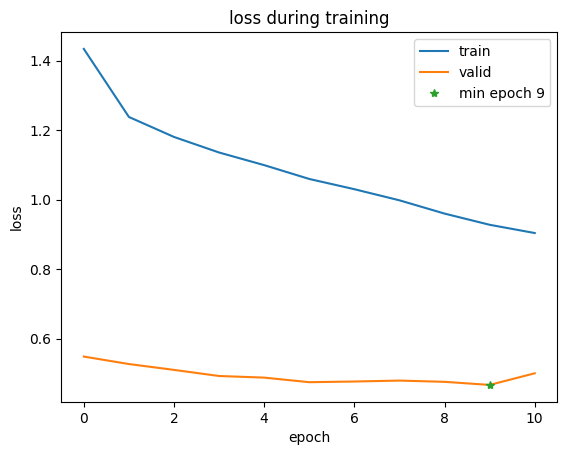

Epoch 11: 100%|██████████| 250/250 [00:03<00:00, 80.17it/s]


[Train] MSE loss: 0.868
[Valid] MSE loss: 0.473


Epoch 12: 100%|██████████| 250/250 [00:02<00:00, 83.59it/s]


[Train] MSE loss: 0.833
[Valid] MSE loss: 0.477


Epoch 13: 100%|██████████| 250/250 [00:02<00:00, 83.85it/s]


[Train] MSE loss: 0.809
[Valid] MSE loss: 0.481


Epoch 14: 100%|██████████| 250/250 [00:03<00:00, 81.74it/s]


[Train] MSE loss: 0.776
[Valid] MSE loss: 0.497


Epoch 15: 100%|██████████| 250/250 [00:02<00:00, 84.13it/s]


[Train] MSE loss: 0.741
[Valid] MSE loss: 0.504


Epoch 16: 100%|██████████| 250/250 [00:03<00:00, 75.96it/s]


[Train] MSE loss: 0.707
[Valid] MSE loss: 0.516


Epoch 17: 100%|██████████| 250/250 [00:03<00:00, 79.95it/s]


[Train] MSE loss: 0.682
[Valid] MSE loss: 0.525


Epoch 18: 100%|██████████| 250/250 [00:02<00:00, 84.33it/s]


[Train] MSE loss: 0.648
[Valid] MSE loss: 0.521


Epoch 19: 100%|██████████| 250/250 [00:03<00:00, 82.64it/s]


[Train] MSE loss: 0.615
[Valid] MSE loss: 0.541


Epoch 20: 100%|██████████| 250/250 [00:03<00:00, 81.92it/s]


[Train] MSE loss: 0.592
[Valid] MSE loss: 0.543


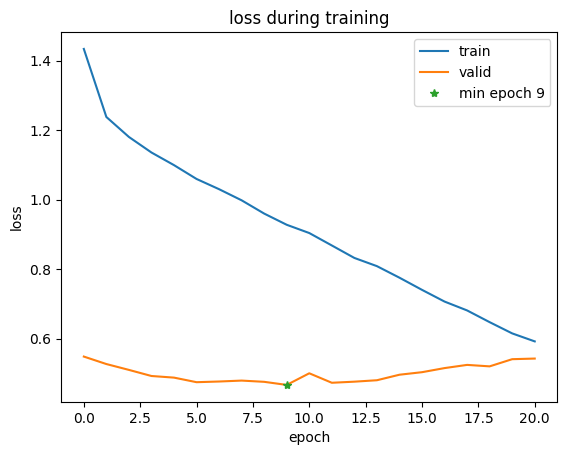

Epoch 21: 100%|██████████| 250/250 [00:02<00:00, 85.07it/s]


[Train] MSE loss: 0.559
[Valid] MSE loss: 0.574


Epoch 22: 100%|██████████| 250/250 [00:03<00:00, 82.60it/s]


[Train] MSE loss: 0.538
[Valid] MSE loss: 0.580


Epoch 23: 100%|██████████| 250/250 [00:03<00:00, 81.22it/s]


[Train] MSE loss: 0.505
[Valid] MSE loss: 0.612


Epoch 24: 100%|██████████| 250/250 [00:02<00:00, 83.56it/s]


[Train] MSE loss: 0.477
[Valid] MSE loss: 0.626


Epoch 25: 100%|██████████| 250/250 [00:02<00:00, 83.54it/s]


[Train] MSE loss: 0.468
[Valid] MSE loss: 0.658


Epoch 26: 100%|██████████| 250/250 [00:03<00:00, 79.24it/s]


[Train] MSE loss: 0.434
[Valid] MSE loss: 0.670


Epoch 27: 100%|██████████| 250/250 [00:03<00:00, 82.63it/s]


[Train] MSE loss: 0.411
[Valid] MSE loss: 0.698


Epoch 28: 100%|██████████| 250/250 [00:03<00:00, 82.68it/s]


[Train] MSE loss: 0.385
[Valid] MSE loss: 0.732
loss increase


In [18]:
if best_epoch != 0:
    model.load_state_dict(torch.load('ckpt_nn.pt', map_location=device))

for epoch in range(best_epoch, epochs+best_epoch):
    total_loss = 0
    model.train()
    for i, (fp, label) in tqdm(enumerate(train_loader_nn),
                               total=len(train_loader_nn),
                               desc=f'Epoch {epoch}'):
        optimizer.zero_grad()
        if cuda: fp, label = fp.cuda(), label.cuda()
        mask = label == MASK
        output = model(fp)
        loss = loss_function(output[~mask], label[~mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    total_loss /= len(train_loader_nn.dataset)
    print(f'[Train] MSE loss: {total_loss:.3f}')
    train_loss_dict[epoch] = total_loss

    model.eval()
    total_valid_loss = 0
    for fp, label in valid_loader_nn:
        if cuda: fp, label = fp.cuda(), label.cuda()
        mask = label == MASK
        output = model(fp)
        loss = loss_function(output[~mask], label[~mask])
        total_valid_loss += loss.item()
    total_valid_loss /= len(valid_loader_nn.dataset)
    valid_loss_dict[epoch] = total_valid_loss
    print(f'[Valid] MSE loss: {total_valid_loss:.3f}')
    argmin, min_loss = get_min(valid_loss_dict)
    if total_valid_loss <= min_loss and epoch > 3:
        # SAVE MODEL
        torch.save(model.state_dict(), 'ckpt_nn.pt')
        best_epoch = epoch

    if epoch - argmin > 20: print('early stop, no decrease'); break
    if total_valid_loss / min_loss > 1.5: print('loss increase'); break

    if epoch % 10 == 0 and epoch != 0:
        plot_loss(train_loss_dict, valid_loss_dict, name='valid')

In [19]:
print('Evaluate on test sets')
model = Classifier(dims).to(device)
model.load_state_dict(torch.load('ckpt_nn.pt', map_location=device))
model.eval()
total_loss = 0
test_meter = Meter()


for i, (fp, labels) in enumerate(test_loader_nn):
    fp, labels = fp.to(device), labels.to(device)
    mask = labels == MASK
    pred = model(fp)
    loss = loss_function(pred[~mask], labels[~mask])

    total_loss += loss.item()
    if i == 0:
        preds_ = pred.cpu()
        labels_ = labels.cpu()
        masks_ = mask.cpu()
    else:
        preds_ = torch.cat([preds_, pred.cpu()], dim=0)
        labels_ = torch.cat([labels_, labels.cpu()], dim=0)
        masks_ = torch.cat([masks_, mask.cpu()], dim=0)

print('total_loss: ', total_loss / len(tests))


if IS_R: reg_evaluate(labels_[~masks_].detach().numpy(),
                      preds_[~masks_].detach().numpy())
else:
    evaluate(labels_[~masks_].detach().numpy(),
             get_preds(0.5, F.sigmoid(preds_[~masks_]).detach().numpy()),
             preds_[~masks_].detach().numpy())

Evaluate on test sets
total_loss:  0.5620409443264915
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.819  &  0.803  &          0.764  &     0.742  &0.864  &0.753 &0.887 &   0.610 &   0.825


In [20]:
import sklearn.metrics as metrics


def reg_evaluate(label_clean, preds_clean):
    mae = metrics.mean_absolute_error(label_clean, preds_clean)
    mse = metrics.mean_squared_error(label_clean, preds_clean)
    rmse = np.sqrt(mse) #mse**(0.5)
    r2 = metrics.r2_score(label_clean, preds_clean)

    # print("Overall results of sklearn.metrics:")
    print("MAE:",mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R-Squared:", r2)

    eval_result_r2 =   f'R2:     {r2:.3f}'
    eval_result_mae =  f'MAE:   {mae:.3f}'
    eval_result_rmse = f'RMSE: {rmse:.3f}'

    return eval_result_r2, eval_result_mae, eval_result_rmse

for i in range(labels_.shape[1]):
    reg_evaluate(labels_[:, i][~masks_[:, i]].detach().numpy(),
                 preds_[:, i][~masks_[:, i]].detach().numpy())

MAE: 1.7881881
MSE: 4.768252
RMSE: 2.1836326
R-Squared: -18.201241905030965
MAE: 2.7482002
MSE: 10.1750765
RMSE: 3.1898396
R-Squared: -66.25111972782607
MAE: 2.1599853
MSE: 7.9658384
RMSE: 2.8223817
R-Squared: -31.872165834879418
MAE: 2.620729
MSE: 10.74578
RMSE: 3.2780757
R-Squared: -42.11662332993502
MAE: 2.073784
MSE: 6.806453
RMSE: 2.608918
R-Squared: -29.387929123121108


In [21]:
for i, name in enumerate(names):
    try: name = name.split('_')[0]
    except: pass
    e_r2, e_mae, e_rmse = reg_evaluate(
                 labels_[:, i][~masks_[:, i]].detach().numpy(),
                 preds_[:, i][~masks_[:, i]].detach().numpy())

    color = mcp.gen_color_normalized(cmap='viridis',
                data_arr=labels_[:, i][~masks_[:, i]].detach().numpy())
    plt.scatter(labels_[:, i][~masks_[:, i]].detach().numpy(),
                preds_[:, i][~masks_[:, i]].detach().numpy(),
                cmap='viridis', marker='.',
                s=10, alpha=0.5, edgecolors='none', c=color)
    plt.xlabel(f'True {name}')
    plt.ylabel(f'Predicted {name}')
    plt.title(f'{name} prediction on test set using NN FP')
    # plt.text(-12, 1, e_r2)
    # plt.text(-12, 0, e_mae)
    # plt.text(-12, -1, e_rmse)
    plt.show()
    plt.close()

MAE: 1.7881881
MSE: 4.768252
RMSE: 2.1836326
R-Squared: -18.201241905030965


NameError: ignored

In [22]:
if IS_R == False:
    for i, name in enumerate(names):
        print('*'*15, name, '*'*15)
        probs = F.sigmoid(preds_[:, i][~masks_[:, i]])
        label = labels_[:, i][~masks_[:, i]]
        probs = probs.cpu().detach().numpy()
        label = label.cpu().detach().numpy()
        assert len(probs) == len(label)
        preds = get_preds(0.5, probs)
        evaluate(label, preds, probs)
        print()

*************** CYP2C19_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.809  &  0.810  &          0.773  &     0.825  &0.794  &0.798 &0.877 &   0.618 &   0.842

*************** CYP2D6_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.868  &  0.729  &          0.699  &     0.508  &0.950  &0.588 &0.848 &   0.521 &   0.655

*************** CYP3A4_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.768  &  0.756  &          0.732  &     0.689  &0.823  &0.710 &0.850 &   0.518 &   0.793

*************** CYP1A2_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE, SP,     F1,     AUC,     MCC,     AP
& 0.834  &  0.834  &          0.823  &     0.827  &0.840  &0.825 &0.911 &   0.668 &   0.901

*************** CYP2C9_Veith ***************
Accuracy, weighted accuracy, precision, recall/SE,